In [1]:
import sys
sys.path.insert(0, '../')
import util.util_diffengine_parsing as p
import sqlite3
import pandas as pd 
import difflib
from IPython.core.display import display, HTML
import pickle
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import numpy as np
from importlib import reload

# Dataset Details

https://archive.org/details/diffengine-diffs

A dataset of 1,058,329 diffs of web pages from the Associated Press, BBC, Calgary Herald, Canada Land, CBC, CNN, Daily Mail, Fox News, Globe and Mail, La Presse, National Post, Reuters, Telegraph, The Rebel, Toronto Star, Toronto Sun and the White House websites. They were collected with the diffengine application by Ryan Bauman, Nick Ruest and Ed Summers.

In [2]:
ls ../data/diffengine-diffs/db

ap.db             cnn.db            nationalpost.db*  torontosun.db*
bbc.db            dailymail.db      reuters.db        whitehouse.db
calgaryherald.db* fox.db            telegraph.db
canadaland.db     globemail.db*     therebel.db*
cbc.db*           lapresse.db*      torontostar.db*


In [3]:
# Whitehouse
conn = sqlite3.connect('../data/diffengine-diffs/db/whitehouse.db')
pd.read_sql("SELECT name FROM sqlite_master WHERE type ='table'", con=conn) ## see tables
pd.read_sql('select * from diff limit 2', con=conn) ## see diff table
pd.read_sql('select * from entry limit 2', con=conn) ## see entry table
entry_version = pd.read_sql('select * from entryversion limit 2', con=conn) ## see entry version table
pd.read_sql('select * from feed limit 5', con=conn) ## see feed table
pd.read_sql('select * from feedentry limit 5', con=conn) ## see feed entry
entry_version['summary'][1] ## see what the 'summary' field is
;

''

# Basic Article-Level Statistics

In [7]:
to_examine = [
    'dailymail.db',
    'ap.db',
    'bbc.db',
    'cbc.db',
    'fox.db',
    'reuters.db',
    'cnn.db',
    'torontosun.db',
]
print('We\'ll look at:')
print()
for e in to_examine:
    print(e)

We'll look at:

dailymail.db
ap.db
bbc.db
cbc.db
fox.db
reuters.db
cnn.db
torontosun.db


In [12]:
import os
from tqdm.auto import tqdm
db_path = '../data/diffengine-diffs/db/'
conn_dict = {}
diffs_dict = {}
entry_vers_dict = {}
for db in tqdm(to_examine):
    print(db)
    name = db.replace('.db', '')
    conn_dict[name] = sqlite3.connect(os.path.join(db_path, db))
    diffs_dict[name] = pd.read_sql('select * from diff', con=conn_dict[name])
    entry_vers_dict[name] = pd.read_sql('select * from entryversion limit 5000', con=conn_dict[name])

In [14]:
## num articles in each database

In [34]:
article_counts = {}
for n, conn in tqdm(conn_dict.items()):
    c = pd.read_sql('select Count(1) from entry', con=conn).iloc[0][0]
    article_counts[n] = c
version_counts = {}
for n, conn in tqdm(conn_dict.items()):
    c = pd.read_sql('select Count(1) from entryversion', con=conn).iloc[0][0]
    version_counts[n] = c

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
entry = pd.read_sql('select * from entry', con=conn)

In [18]:
pd.Series(article_counts).sort_values()

torontosun    19166
ap            23101
reuters       32430
bbc           42846
cbc           54321
dailymail     59901
cnn           69533
fox           86845
dtype: int64

In [36]:
pd.Series(version_counts).sort_values()

torontosun     46353
ap             97314
bbc            99082
fox           117171
cnn           117202
reuters       143303
dailymail     166260
cbc           387292
dtype: int64

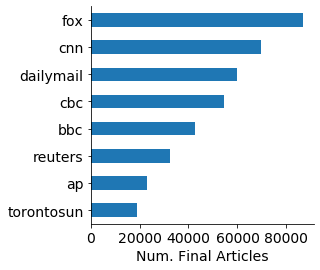

In [16]:
ax = (pd.Series(article_counts)
      .sort_values()
      .plot(kind='barh', figsize=(4, 4))
     )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Num. Final Articles');

In [1032]:
flatten = lambda l: [x for l_s in l for x in l_s]

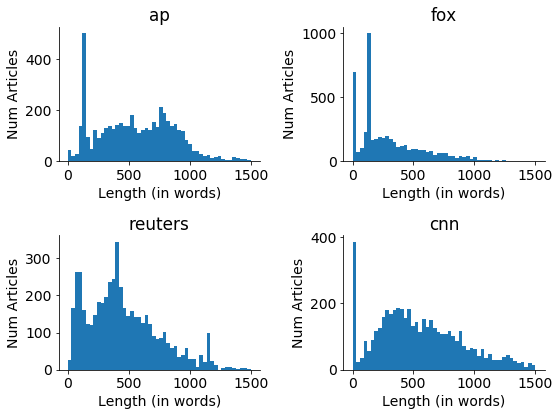

In [1034]:
f, axarr = plt.subplots(2, 2, figsize=(8, 6))
axarr = flatten(axarr)
for idx, (name, entry_version) in enumerate(entry_vers_dict.items()):
    ax = (entry_version['summary']
            .str.split()
            .str.len()
            .hist(bins=50, range=(0, 1500), 
#                   alpha=.5,
                  label=name, ax=axarr[idx])
    )

    axarr[idx].grid(False)
    axarr[idx].spines['right'].set_visible(False)
    axarr[idx].spines['top'].set_visible(False)
    axarr[idx].set_ylabel('Num Articles')
    axarr[idx].set_xlabel('Length (in words)')
    axarr[idx].set_title(name)
plt.tight_layout()

In [ ]:
fox_article_len = (fox_entry_version['summary']
 .str.split()
 .str.len()
)

In [949]:
fox_entry_version['len'] = fox_article_len
fox_entry_version['len_bin'] = fox_article_len.pipe(lambda s: pd.cut(s, np.linspace(0, 1500, 51)))

What's the weird spike that many of these articles have between 120 and 150 words?

We look at a sample of articles that have word-length between 120 and 150, and see nothing pathological.

##### Sample of articles with word-len: (120, 150]

In [1386]:
for i in range(3):
    print()
    print(fox_entry_version
     .loc[lambda df: df['len_bin'] == df['len_bin'].cat.categories[4]]
     ['summary'].iloc[i]
    )


<p>ROME – Three earthquakes hit central Italy in the space of an hour Wednesday, with tremors felt in the capital.</p> <p>There were no immediate reports of casualties.</p> <p>The first quake, with a preliminary magnitude of 5.3 hit the region north of Amatrice at about 10:25 a.m., according to the U.S. Geological Survey. A second quake with a magnitude of 5.7 hit the same area about 50 minutes later, and ten minutes later a third was measured at magnitude-5.3.</p> <p>The mountainous Amatrice region was shaken by three quakes last year, killing nearly 300 people and causing significant damage to older buildings.</p> <p>The region is about 62 miles northeast of Rome.</p> <p>Antonio Tajani, an Italian politician who is president of the European Parliament, said tremors were "felt as far as Rome (but it) appears there are no victims."</p> <p></p>

<p>A man was injured Tuesday night after setting a fire outside the Trump International Hotel in Washington D.C., fire officials said.</p> <p>

# Diff Article-Level Statistics

We have a table containing the revision update ids and their creation times.

In [1003]:
diffs_dict['fox'].head(3)

,id,old_id,new_id,created,tweeted,blogged
0,1,5,35,2017-01-18 15:45:10.708097,2017-01-18 15:45:13.415430,None
1,2,36,40,2017-01-18 16:15:06.081604,2017-01-18 16:15:09.345384,None
2,3,42,48,2017-01-18 16:30:49.311923,2017-01-18 16:30:52.143213,None


In [ ]:
all_diffs_lists_dict = {}
for k, diffs in diffs_dict.items():
    print('running: %s' % k)
    all_diffs_lists_dict[k] = group_using_diffs(diffs)

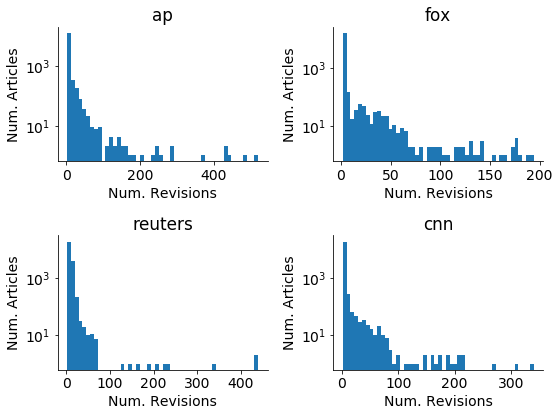

In [1013]:
f, axarr = plt.subplots(2, 2, figsize=(8, 6))
axarr = [ax for axarr_s in axarr for ax in axarr_s]
for idx, (k, all_lists) in enumerate(all_diffs_lists_dict.items()):
    pd.Series(all_lists).str.len().hist(bins=50, ax=axarr[idx])
    axarr[idx].semilogy()
    axarr[idx].set_ylabel('Num. Articles')
    axarr[idx].set_xlabel('Num. Revisions')
    axarr[idx].spines['top'].set_visible(False)
    axarr[idx].spines['right'].set_visible(False)
    axarr[idx].grid(False)
    axarr[idx].set_title(k)
    
plt.tight_layout()

In [1395]:
entry_vers_dict['reuters'] = pd.read_sql('select * from entryversion', con=conn_dict['reuters'])

In [1402]:
reuters_entry_version = entry_vers_dict['reuters']

In [ ]:
reuters_entry_version['entry_id'].value_counts().loc[lambda s: s<100]
reuters_entry_version['entry_id'].value_counts().value_counts().sort_index()
reuters_entry_version.loc[lambda df: df['entry_id'] == 818]['url'].value_counts()

Some of these articles that have >400 revisions are section fronts or other updating, dynamic articles... how can we determine when an article is a complete rewrite vs. a normal republication?

In [1387]:
top_entry_ids = (ap_entry_version['entry_id']
 .value_counts()
 .loc[lambda s: s < 50]
 .index[:5]
)

print('Example of Article Urls with ~ 100 Revisions:')
for entry_id in top_entry_ids:
    print()
    print(ap_entry_version.loc[lambda df: df['entry_id'] == entry_id]['url'].value_counts())

Example of Article Urls with ~ 100 Revisions:

http://hosted.ap.org/dynamic/stories/E/EU_TURKEY_FAILED_COUP?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT    46
http://hosted.ap.org/dynamic/stories/E/EU_TURKEY_FAILED_COUP?SITE=AP&TEMPLATE=DEFAULT&SECTION=HOME     1
http://hosted.ap.org/dynamic/stories/E/EU_TURKEY_FAILED_COUP?TEMPLATE=DEFAULT&SITE=AP&SECTION=HOME     1
http://hosted.ap.org/dynamic/stories/E/EU_TURKEY_FAILED_COUP?SECTION=HOME&SITE=AP&TEMPLATE=DEFAULT     1
Name: url, dtype: int64

http://hosted.ap.org/dynamic/stories/U/US_AARON_HERNANDEZ?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT    49
Name: url, dtype: int64

http://hosted.ap.org/dynamic/stories/U/US_DEMOCRATS_LIBERAL_OUTCRY?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT    48
Name: url, dtype: int64

http://hosted.ap.org/dynamic/stories/U/US_HOLLAND_TUNNEL_WEAPONS_CACHE?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT    45
http://hosted.ap.org/dynamic/stories/U/US_HOLLAND_TUNNEL_WEAPONS_CACHE?SECTION=HOME&SITE=AP&TEMPLATE=DEFAULT     1
http://hosted.a

In [1445]:
short_lists = list(filter(lambda x: len(x) < 50, all_diffs_lists_dict['ap']))
ap_entry_version.loc[lambda df: df['id'].isin(short_lists[0])]

,id,title,url,summary,created,archive_url,entry_id
0,1,News from The Associated Press,http://hosted.ap.org/dynamic/stories/U/US_OBAM...,<p> WASHINGTON (AP) -- Embracin...,2017-01-18 15:48:03.845167,https://wayback.archive.org/web/20170118154824...,1
10,11,News from The Associated Press,http://hosted.ap.org/dynamic/stories/U/US_OBAM...,<p> WASHINGTON (AP) -- Embracin...,2017-01-18 16:00:03.432431,https://wayback.archive.org/web/20170118160023...,1
111,112,News from The Associated Press,http://hosted.ap.org/dynamic/stories/U/US_OBAM...,<p> WASHINGTON (AP) -- Embracin...,2017-01-18 19:30:03.362584,https://wayback.archive.org/web/20170118193024...,1


In [1449]:
ap_entry_version['created'] = pd.to_datetime(ap_entry_version['created'])

In [1482]:
time_deltas = []
for list_idx, s in tqdm(enumerate(all_diffs_lists_dict['ap']), total=len(all_diffs_lists_dict['ap'])):
    delta = (
        ap_entry_version
            .loc[lambda df: df['id'].isin(s)]['created']
            .pipe(lambda s: s.max() - s.min())
    )
    time_deltas.append({
        'delta': delta,
        'list_len': len(s),
        'list_idx': list_idx
    })

In [1483]:
time_delta_df = (pd.DataFrame(time_deltas)
                 .assign(day_delta=lambda df: df['delta'].apply(lambda x: x.total_seconds() / (60 * 60 * 24)))
                )

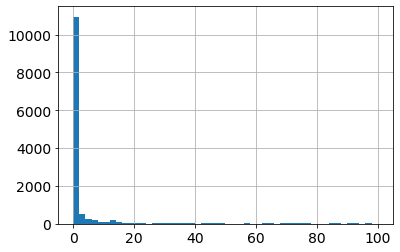

In [1471]:
(time_delta_df['day_delta']
 .hist(bins=50, range=(0, 100))
)

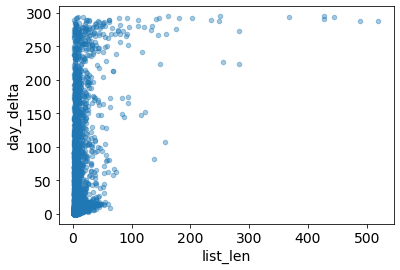

In [1480]:
time_delta_df[['list_len', 'day_delta']].plot(kind='scatter', x='list_len', y='day_delta', alpha=.4)

In [1513]:
(time_delta_df
#  .loc[lambda df: df['list_len'] == 2]
 .sort_values('day_delta', ascending=False)
 .loc[lambda df: df['day_delta'] < 20]
 .head()
#  .shape
#  ['day_delta']
)

,delta,list_len,list_idx,day_delta
4693,19 days 23:54:10.598361,3,4693,19.995956
6151,19 days 23:39:15.890577,7,6151,19.985601
5138,19 days 23:13:44.702573,2,5138,19.967879
3631,19 days 20:50:08.614878,8,3631,19.868155
1773,19 days 17:54:09.727770,30,1773,19.745946


In [1514]:
all_diffs_lists_dict['ap'][4693]

[36775, 36839, 41530]

In [1517]:
s_idx = 1
a1, a2 = (ap_entry_version
 .loc[lambda df: df['id'].isin(all_diffs_lists_dict['ap'][4693])]['summary']
 .pipe(lambda s: (s.iloc[s_idx], s.iloc[s_idx+1]))
)

In [1518]:
display(HTML(p.list_to_html(p.rolling_window(p.output_diff_lists(a1, a2)))))

# Let's Dive into the text differences of these Diffs

## Calculating the text differences

`difflib.ndiff`: "The basic algorithm predates, and is a little fancier than, an algorithm published in the late 1980’s by Ratcliff and Obershelp under the hyperbolic name “gestalt pattern matching.” " https://docs.python.org/3/library/difflib.html

The vanilla "fancier than Ratcliff and Obershelp" algorithm on the character level does the following:

In [1643]:
reload(p)

<module 'util.util_diffengine_parsing' from '../util/util_diffengine_parsing.py'>

In [ ]:
ap_entry_version = pd.read_sql('select * from entryversion', con=conn_dict['ap'])

In [1644]:
d = p.diffHandler(split_words=True, window_size=5)

In [1645]:
display(HTML(d.list_to_html(d.output_diff_lists(*t_diffs[3]))))

In [1646]:
display(HTML(d.list_to_html(
d.rolling_window(d.output_diff_lists(*t_diffs[3]), window_size=5)
)))

In [1599]:
d = p.diffHandler()

In [1580]:
t = (ap_entry_version
 .loc[lambda df: df['id'].isin(all_diffs_lists_dict['ap'][1])]
 .sort_values('created')
 ['summary']
)

t_diffs = list(zip(t[:-1], t[1:]))
t_list = p.output_diff_lists(*t_diffs[3])
t_rolled_list = p.rolling_window(t_list, window_size=20)

In [1581]:
display(HTML(p.list_to_html(t_list)[:5003] + '</span>.........'))

-----------------------------------------------------

Because it seeks to maximize the overlap, it gets these garbled phrases. To fix this, we implemented a rolling-window merge operation. This gist of this algorithm is to:

* While not done:
  * Iterate through each diff block, _i_ in the text sequentially.
    * (where a diff block is a continuous block of characters sharing the same color: green, red or clear)
  * If diff block _i+1_ has length > window size _w_, __merge__

We develop a number of heuristics on how to merge with the contiguous blocks around depending on whether blocks _i-1,  i, i+1, i+2_ are green, red or clear.

Sparing the gory details for the paper appendix, here is the output, with window _w=20_ characters. We use this merge algorithm going forward.

----------------------------------------------------

In [1382]:
display(HTML(list_to_html(t_rolled_list)[:1095] + '</span>.....'))

-------------------------------------------------------------------
(__NOTE__: Sz-rung suggested doing the diffs and merge operations on the word-level instead of the character-level which seems like a really good idea)

#### Sanity Check

After our merge operation, as a sanity check, we can still recover the original articles _t_ and _t+1_

In [1075]:
def check_processed_diff(article_vers_pair, processed_diff):
    checks = []
    for orig_idx, p_sym in [(0, '-'), (1, '+')]:
        ## process orig
        orig_check = article_vers_pair[orig_idx].replace('<p>', '').replace('</p>', '')
        orig_check = ' '.join(orig_check.split())

        ## process 
        rolled_check = ''.join(
            pd.DataFrame(processed_diff)
             .loc[lambda df: df['label'].isin([' ', p_sym])]
             ['text'].tolist()
        ).replace('<p>', '').replace('</p>', '')
        rolled_check = ' '.join(rolled_check.split())

        ## perform check
        t_list = p.output_diff_lists(orig_check, rolled_check)
        remove_spaces = list(filter(lambda x: ''.join(x['text'].split()) != '', t_list))
        checks.append(
            [p_sym, all(map(lambda x: x['label'] == ' ', remove_spaces))]
        )
    return checks

In [1083]:
print('Sanity Check, sans rolling window:')
print(check_processed_diff(t_diffs[3], t_list))
print()
print('Sanity Check, with rolling window:')
print(check_processed_diff(t_diffs[3], t_rolled_list))

Sanity Check, sans rolling window:
[['-', True], ['+', True]]

Sanity Check, with rolling window:
[['-', True], ['+', True]]


# Diff Text-Level Statistics

In [587]:
from tqdm.auto import tqdm

## Article Overlap

In [1638]:
from difflib import SequenceMatcher

nd_diff_ratio = []
for old_id, new_id in tqdm(diffs_dict['ap'][['old_id', 'new_id']].itertuples(index=False), total=len(diffs_dict['ap'])):
    a1, a2 = (
        ap_entry_version
              .loc[lambda df: df['id'].isin([old_id, new_id])]
              ['summary']
             )
    
    r = SequenceMatcher(None, a1, a2).ratio()
    nd_diff_ratio.append(r)

Text(0.5, 0, 'Diff. Ratio')

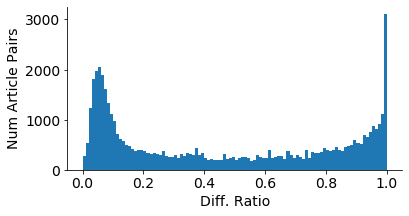

In [1654]:
ax = pd.Series(nd_diff_ratio).hist(bins=100, figsize=(6,3))
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Num Article Pairs')
ax.set_xlabel('Diff. Ratio')

In [1711]:
diffs_dict['ap'].loc[lambda df: (df['diff_ratio'] > .2) & (df['diff_ratio'] < .99)].shape

(28196, 7)

In [1689]:
diffs_dict['ap'].loc[lambda df: df['diff_ratio'] <= .2].shape

(19247, 7)

In [1655]:
diffs_dict['ap']['diff_ratio'] = nd_diff_ratio

In [1677]:
d = p.diffHandler(window_size=15)

In [1707]:
a1, a2 = (diffs_dict['ap']
 .loc[lambda df: df['diff_ratio'] >.990]
 .sort_values('diff_ratio', ascending=True)
 [['old_id', 'new_id']]
 .iloc[3]
 .pipe(lambda s: ap_entry_version.loc[lambda df: df['id'].isin(s)])
 ['summary']
)

In [1708]:
display(HTML(d.list_to_html(d.rolling_window(d.output_diff_lists(a1, a2)))))

## growth of article over time

In [ ]:
sizes_over_time = []
for single_article_diff_list in tqdm(short_lists):
    size_over_time = (
            ap_entry_version
             .loc[lambda df: df['id'].isin(single_article_diff_list)]
             .sort_values('created')
             ['summary'].str.len()
            .pipe(lambda s: s/s.max())
    )
    sizes_over_time.append(size_over_time)

In [1114]:
sizes_over_time_s = (pd.Series(list(map(lambda x: x.tolist(), sizes_over_time)))
                     .to_frame('sizes')
                     .assign(length=lambda df: df['sizes'].str.len())
                    )

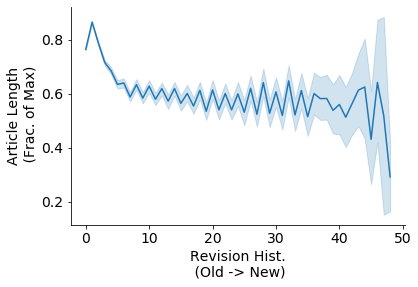

In [1141]:
t = (sizes_over_time_s['sizes']
 .apply(pd.Series)
 .unstack()
 .reset_index()
)

ax = sns.lineplot(data=t, x="level_0", y=0)
ax.set_xlabel('Revision Hist.\n (Old -> New)')
ax.set_ylabel('Article Length\n (Frac. of Max)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

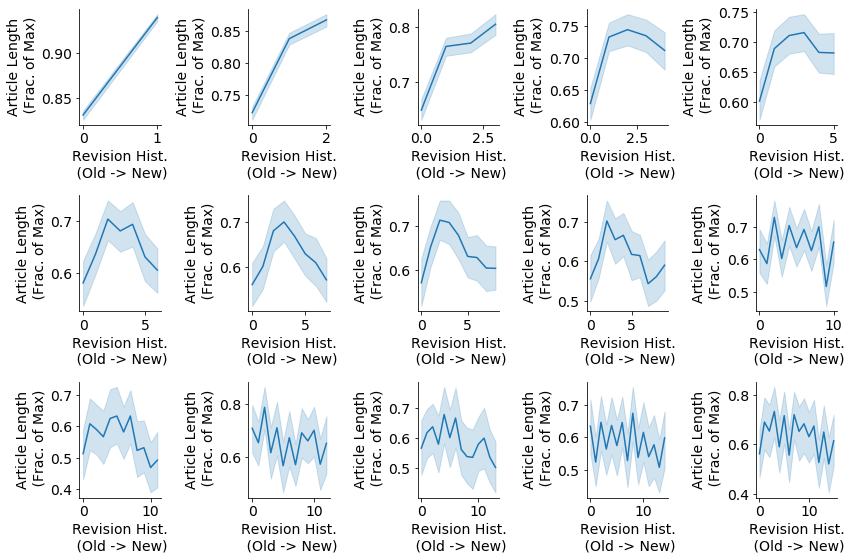

In [1142]:
f, axarr = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
axarr = flatten(axarr)

for i in range(15):
    t = (sizes_over_time_s
     .loc[lambda df: df['length'] == i + 2]['sizes']
     .apply(pd.Series)
     .unstack()
     .reset_index()
    )

    sns.lineplot(data=t, x="level_0", y=0, ax=axarr[i])
    axarr[i].set_xlabel('Revision Hist.\n (Old -> New)')
    axarr[i].set_ylabel('Article Length\n (Frac. of Max)')
    axarr[i].spines['right'].set_visible(False)
    axarr[i].spines['top'].set_visible(False)
    
plt.tight_layout()

## How Likely is a Change, throughout the article?

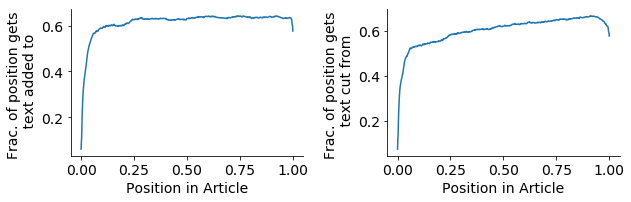

In [1260]:
k = 801
pos_counts = []
for a in tqdm(article_diffs):
    diff_list_rolled = a['diff_list_rolled']
    diff_list_df = pd.DataFrame(diff_list_rolled).loc[lambda df: df['label'].isin([' ', '+'])]
    if len(diff_list_df) > 0:
        t = (diff_list_df
     .assign(text_end=lambda df: df['text'].str.len().cumsum())
     .assign(text_start=lambda df: [0] + df['text_end'].tolist()[:-1])
     .assign(bin_start=lambda df: pd.cut( df['text_start'] / df['text_end'].max(), np.linspace(0, 1, k), right=False))
     .assign(bin_end=lambda df: pd.cut( df['text_end'] / df['text_end'].max(), np.linspace(0, 1, k), right=True))
     .assign(spread=lambda df:  df
 .apply(lambda x: (x['bin_start'] <= df['bin_start'].cat.categories) & (df['bin_start'].cat.categories <= x['bin_end']), axis=1)
 .apply(lambda x: x.astype(int)))
     .loc[lambda df: df['label'] == '+']#['spread'].sum()
      )
        
        pos_counts.append(t)

k = 801
neg_counts = []
for a in tqdm(article_diffs):
    diff_list_rolled = a['diff_list_rolled']
    diff_list_df = pd.DataFrame(diff_list_rolled).loc[lambda df: df['label'].isin([' ', '-'])]
    if len(diff_list_df) > 0:
        t = (diff_list_df
     .assign(text_end=lambda df: df['text'].str.len().cumsum())
     .assign(text_start=lambda df: [0] + df['text_end'].tolist()[:-1])
     .assign(bin_start=lambda df: pd.cut( df['text_start'] / df['text_end'].max(), np.linspace(0, 1, k), right=False))
     .assign(bin_end=lambda df: pd.cut( df['text_end'] / df['text_end'].max(), np.linspace(0, 1, k), right=True))
     .assign(spread=lambda df:  df
 .apply(lambda x: (x['bin_start'] <= df['bin_start'].cat.categories) & (df['bin_start'].cat.categories <= x['bin_end']), axis=1)
 .apply(lambda x: x.astype(int)))
     .loc[lambda df: df['label'] == '-']#['spread'].sum()
      )
        
        neg_counts.append(t)

mean_pos_positions = pd.concat(list(map(lambda x: pd.Series(x['spread'].sum()), pos_counts)), axis=1).mean(axis=1)
mean_neg_positions = pd.concat(list(map(lambda x: pd.Series(x['spread'].sum()), neg_counts)), axis=1).mean(axis=1)

f, axarr = plt.subplots(1, 2, figsize=(9, 3))

(mean_pos_positions
      .reset_index().assign(idx=lambda df: np.linspace(0, 1, 800)).set_index('idx')[0]
      .plot(ax=axarr[0])
     )

(mean_neg_positions
      .reset_index().assign(idx=lambda df: np.linspace(0, 1, 800)).set_index('idx')[0]
      .plot(ax=axarr[1])
     )

axarr[0].set_ylabel('Frac. of position gets \n text added to')
axarr[1].set_ylabel('Frac. of position gets \n text cut from')

for ax in axarr:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Position in Article')
    
plt.tight_layout()

In [ ]:
# article_diffs = []

for single_article_diff_list in tqdm(short_lists[len(article_diffs):]):
    entry_id, single_article_entries = (
        ap_entry_version
         .loc[lambda df: df['id'].isin(single_article_diff_list)]
         .sort_values('created')
         .pipe(lambda df: (df['entry_id'].unique()[0], df['summary']))
    )
    
    entry_version_ids = list(zip(single_article_diff_list[:-1], single_article_diff_list[1:]))
    single_article_entry_pairs = list(zip(single_article_entries[:-1], single_article_entries[1:]))

    for entry_version_id, one_entry_pair in zip(entry_version_ids, single_article_entry_pairs):
        single_article_one_diff_list = output_diff_lists(*one_entry_pair)
        single_article_one_rolled_diff_list = rolling_window(single_article_one_diff_list, window_size=20)
        
        article_diffs.append({
            'entry_id': entry_id,
            'entry_version_id': entry_version_id,
            'diff_entry_ids': single_article_diff_list,
            'diff_list': single_article_one_diff_list,
            'diff_list_rolled': single_article_one_rolled_diff_list
        })

In [1127]:
article_diffs_df = pd.DataFrame(article_diffs)

In [1135]:
article_diffs_df = article_diffs_df.merge(
    article_diffs_df['entry_id'].value_counts().to_frame('num_revisions_total'),
    left_on='entry_id',
    right_index=True
)

In [1148]:
article_diffs_df['order'] = (article_diffs_df
 .assign(entry_first=lambda df: df['entry_version_id'].str.get(0))
 .groupby('entry_id')['entry_first']
 .rank("dense")
)

## num additions/subtractions per revision

In [1155]:
revision_counts_overall = (article_diffs_df['diff_list_rolled']
 .apply(lambda x: pd.Series(list(map(lambda y: y['label'], x))).value_counts()
)).fillna(0)

Text(0.5, 0, 'Num. Edits per revision')

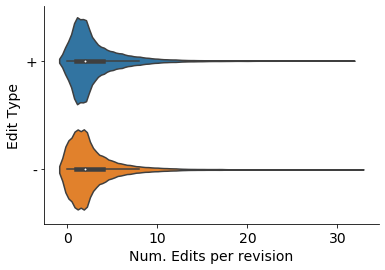

In [1186]:
ax = sns.violinplot(
    data=revision_counts_overall[['+', '-']].unstack().reset_index(), 
    y='level_0', 
    x = 0,
#     showfliers=False
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Edit Type')
ax.set_xlabel('Num. Edits per revision')

## Length of additions/subtractions

### overall length of words added/subtracted over all revisions

In [1222]:
len_by_edit = []
for x in tqdm(article_diffs_df['diff_list_rolled']):
    len_by_edit.append(
        (pd.DataFrame(x)
         .loc[lambda df: df['label'] != ' ']
         .assign(text_len=lambda df: df['text'].str.split().str.len())
         [['label', 'text_len']]
        #  .groupby('label')['text_len'].sum()
        )
    )

In [1226]:
overall_len_s = pd.concat(list(map(lambda x: x.groupby('label')['text_len'].sum(), len_by_edit)), axis=1).T

Text(0.5, 0, 'Length of all edits per revision (words)')

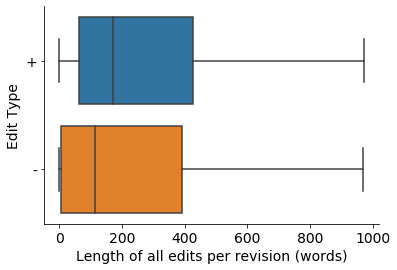

In [1227]:
ax = sns.boxplot(data=overall_len_s.fillna(0).unstack().reset_index(), y='level_0', x=0, showfliers=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Edit Type')
ax.set_xlabel('Length of all edits per revision (words)')

### Mean length of all individual additions/subtractions, over all revisions

In [1228]:
len_of_all_edits = pd.concat(len_by_edit)

Text(0.5, 0, 'Length of edit per individual revision (words)')

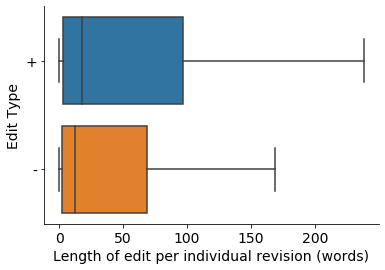

In [1251]:
ax = sns.boxplot(
    data=len_of_all_edits.sort_values('label'), 
    y='label', 
    x='text_len', 
    showfliers=False,
#     color=['rgba(0,255,0,.5)', 'rgba(255,0,0,.5)']
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Edit Type')
ax.set_xlabel('Length of edit per individual revision (words)')

### mean length of all individual additions/subtractions, by revision number

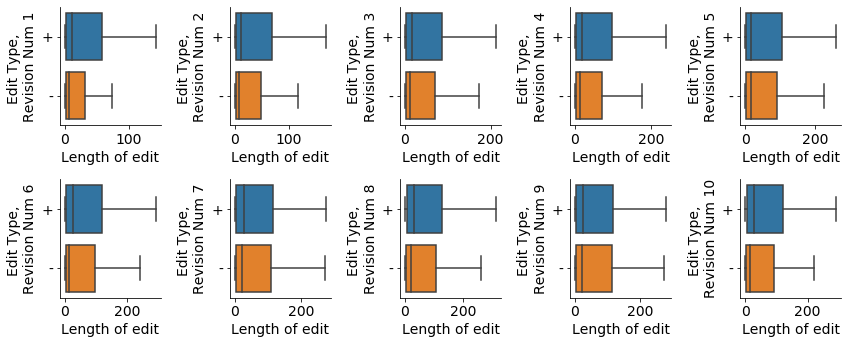

In [1259]:
f, axarr = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axarr = flatten(axarr)

for i in tqdm(range(1, 11)):
    t_art = article_diffs_df.loc[lambda df: df['order'] == i]
    len_by_edit_r = []
    for x in t_art['diff_list_rolled']:
        len_by_edit_r.append(
            (pd.DataFrame(x)
             .loc[lambda df: df['label'] != ' ']
             .assign(text_len=lambda df: df['text'].str.split().str.len())
             [['label', 'text_len']]
            #  .groupby('label')['text_len'].sum()
            )
        )
    
    len_of_all_edits_r = pd.concat(len_by_edit_r)
    sns.boxplot(
        data=len_of_all_edits_r.sort_values('label'), 
        y='label', 
        x='text_len', 
        showfliers=False,
        ax=axarr[i-1]
    )
    axarr[i-1].spines['right'].set_visible(False)
    axarr[i-1].spines['top'].set_visible(False)
    axarr[i-1].set_ylabel('Edit Type, \nRevision Num %s' % i)
    axarr[i-1].set_xlabel('Length of edit')
        
plt.tight_layout()

## characterization of the additions vs. subtractions
### word frequency relative to baseline?

In [1268]:
from sklearn.feature_extraction.text import CountVectorizer

In [1310]:
cv = CountVectorizer(min_df=.01, max_df=.6, stop_words='english')

In [1293]:
diff_list_rolled = pd.DataFrame(flatten(article_diffs_df['diff_list_rolled'].tolist()))

In [1342]:
overall_word_counts = cv.fit_transform(ap_entry_version['summary'])
baseline_word_counts = np.array(overall_word_counts.sum(axis=0))[0]
baseline_word_counts_s = pd.Series(baseline_word_counts, index=pd.Series(cv.vocabulary_).sort_values().index)

In [1343]:
pos_word_counts = cv.transform(diff_list_rolled.loc[lambda df: df['label'] == '+']['text'])
pos_word_counts = np.array(pos_word_counts.sum(axis=0))[0]
pos_word_counts_s = pd.Series(pos_word_counts, index=pd.Series(cv.vocabulary_).sort_values().index)

In [1344]:
neg_word_counts = cv.transform(diff_list_rolled.loc[lambda df: df['label'] == '-']['text'])
neg_word_counts = np.array(neg_word_counts.sum(axis=0))[0]
neg_word_counts_s = pd.Series(neg_word_counts, index=pd.Series(cv.vocabulary_).sort_values().index)

In [1345]:
neut_word_counts = cv.transform(diff_list_rolled.loc[lambda df: df['label'] == ' ']['text'])
neut_word_counts = np.array(neut_word_counts.sum(axis=0))[0]
neut_word_counts_s = pd.Series(neut_word_counts, index=pd.Series(cv.vocabulary_).sort_values().index)

In [1348]:
k = 10
## positive
pos_top_b = (pos_word_counts_s
 .pipe(lambda s: s / baseline_word_counts_s)
 .sort_values(ascending=False)
 .pipe(lambda s: pd.DataFrame({'most lik.': s.index[:k], 'least lik.': s.index[-k:]}))
)
pos_top_b.columns = pd.MultiIndex.from_arrays([['Additions', 'Additions'], pos_top_b.columns.tolist()])

## neutral
neut_t_b = (neut_word_counts_s
.pipe(lambda s: s / baseline_word_counts_s)
 .sort_values(ascending=False)
 .pipe(lambda s: pd.DataFrame({'most lik.': s.index[:k], 'least lik.': s.index[-k:]})))
neut_t_b.columns = pd.MultiIndex.from_arrays([['Remain', 'Remain'], ['most lik.', 'least lik.']])

neg_t_b = (neg_word_counts_s
.pipe(lambda s: s / baseline_word_counts_s)
 .sort_values(ascending=False)
 .pipe(lambda s: pd.DataFrame({'most lik.': s.index[:k], 'least lik.': s.index[-k:]})))
neg_t_b.columns = pd.MultiIndex.from_arrays([['Remove', 'Remove'], ['most lik.', 'least lik.']])

In [1349]:
pd.concat([pos_top_b, neut_t_b, neg_t_b], axis=1)

Additions                     Remain                 Remove            
   most lik.   least lik.     most lik.  least lik.  most lik.  least lik.
0       roof     olympics       somalia    emmanuel       roof      harvey
1   patriots    weinstein         visas       yield   patriots   weinstein
2      super   currencies  inauguration      macron      super       qatar
3      brady         seng          snow  misconduct       camp  harassment
4       camp   harassment      refugees  harassment       snow        seng
5       snow     parkland       refugee   composite      brady   hurricane
6  travelers  pyeongchang          mall       cents      fence    parkland
7    cleared        kospi           ban    parkland    cleared  currencies
8      fence       nikkei     netanyahu   weinstein  travelers       kospi
9       bowl       nasdaq         sworn      nasdaq       bowl      nikkei

# TODO

pyramid method 

content units that were added/changed

openAI tuples

measure revisions in terms of content units

Sit down with Lina and ask how do journalists measure

What is the time duration of the corrections?

Hypotheses are changed first? Then background?

Discourse of the edits?

After you're done, might be good to test on another dataset

Can Bloomberg Automated artilces have 

In [902]:
with open('cache/2021-01-07__ap-article-diffs.pkl', 'wb') as f:
    pickle.dump(article_diffs, f)